# Example 9 - Faulted Layers

This example will show how to convert the geological map below using ``GemGIS`` to a `GemPy` model. This example is based on digitized data. The area is 2977 m wide (W-E extent) and 3731 m high (N-S extent). The model represents three faulted layers. The map has been georeferenced with QGIS. The stratigraphic boundaries were digitized in QGIS. Strikes lines were digitized in QGIS as well and will be used to calculate orientations for the `GemPy` model. The contour lines were also digitized and will be interpolated with `GemGIS` to create a topography for the model. 

<img src="../images/cover_example09.png" width="800">

Map Source: An Introduction to Geological Structures and Maps by G.M. Bennison

## Import GemGIS

If you have installed ``GemGIS`` via pip, you can import ``GemGIS`` like any other package. If you have downloaded the repository, append the path to the directory where the ``GemGIS`` repository is stored and then import ``GemGIS``. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import geopandas as gpd
import rasterio 

In [3]:
file_path = 'data/example09/'
gg.download_gemgis_data.download_tutorial_data(filename="example09_faulted_layers.zip", dirpath=file_path)

## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by interpolating contour lines digitized from the georeferenced map using the `SciPy` Radial Basis Function interpolation wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 

<img src="../images/dem_example09.png" width="800">

In [4]:
topo = gpd.read_file(file_path + 'topo9.shp')
topo.head()

,id,Z,geometry
0,None,200,"LINESTRING (867.721 3.054, 905.213 37.662, 962..."
1,None,300,"LINESTRING (180.750 7.091, 266.116 75.731, 321..."
2,None,400,"LINESTRING (3.094 646.765, 63.082 692.332, 171..."
3,None,500,"LINESTRING (3.671 1124.357, 90.768 1186.652, 2..."
4,None,600,"LINESTRING (4.825 1626.175, 82.693 1677.510, 1..."


### Interpolating the contour lines

In [5]:
topo_raster = gg.vector.interpolate_raster(gdf=topo, value='Z', method='rbf', res=10)

### Plotting the raster

Text(186.60548289738435, 0.5, 'Y [m]')

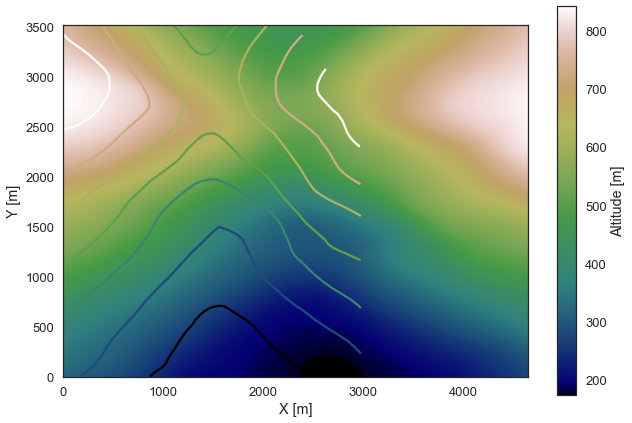

In [6]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(1)
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = plt.imshow(topo_raster, origin='lower', extent=[0,4642,0,3519], cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as as raster is already provided with the example data. 

### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [7]:
topo_raster = rasterio.open(file_path + 'raster9.tif')

## Interface Points of stratigraphic boundaries

The interface points will be extracted from LineStrings digitized from the georeferenced map using QGIS. It is important to provide a formation name for each layer boundary. The vertical position of the interface point will be extracted from the digital elevation model using the `GemGIS` function `gg.vector.extract_xyz()`. The resulting GeoDataFrame now contains single points including the information about the respective formation. 

<img src="../images/interfaces_example09.png" width="800">

In [8]:
interfaces = gpd.read_file(file_path + 'interfaces9.shp')
interfaces.head()

,id,formation,geometry
0,None,A,"LINESTRING (4.825 1655.015, 134.029 1510.814, ..."
1,None,B,"LINESTRING (573.552 2032.244, 637.000 1868.432..."
2,None,A,"LINESTRING (3.671 2628.080, 119.032 2559.441, ..."
3,None,B,"LINESTRING (6.555 3203.152, 225.740 3105.672, ..."
4,None,B,"LINESTRING (1979.796 1736.344, 1999.407 1814.7..."


### Extracting Z coordinate from Digital Elevation Model

In [9]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=topo_raster)
interfaces_coords = interfaces_coords.sort_values(by='formation', ascending=False)
interfaces_coords.head()

,formation,geometry,X,Y,Z
95,F,POINT (2973.626 1660.206),2973.63,1660.21,612.70
87,F,POINT (1734.655 1726.538),1734.65,1726.54,351.47
79,F,POINT (4.825 2222.588),4.82,2222.59,741.10
80,F,POINT (397.627 2107.228),397.63,2107.23,655.76
81,F,POINT (631.809 2029.936),631.81,2029.94,577.42


### Plotting the Interface Points

Text(145.34152470588262, 0.5, 'Y [m]')

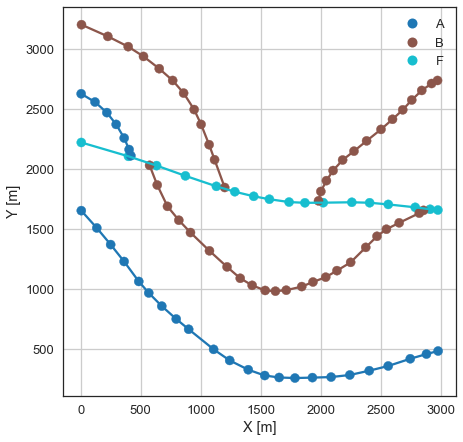

In [10]:
fig, ax = plt.subplots(1)

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Orientations from Strike Lines

Strike lines connect outcropping stratigraphic boundaries (interfaces) of the same altitude. In other words: the intersections between topographic contours and stratigraphic boundaries at the surface. The height difference and the horizontal difference between two digitized lines is used to calculate the dip and azimuth and hence an orientation that is necessary for `GemPy`. In order to calculate the orientations, each set of strikes lines/LineStrings for one formation must be given an id number next to the altitude of the strike line. The id field is already predefined in QGIS. The strike line with the lowest altitude gets the id number `1`, the strike line with the highest altitude the the number according to the number of digitized strike lines. It is currently recommended to use one set of strike lines for each structural element of one formation as illustrated. 

<img src="../images/orientations_example06.png" width="800">

In [11]:
strikes = gpd.read_file(file_path + 'strikes9.shp')
strikes.head()

,id,formation,Z,geometry
0,1,F,400,"LINESTRING (1196.498 1839.015, 1975.758 1721.924)"
1,2,F,500,"LINESTRING (863.107 1948.030, 2263.005 1724.231)"
2,3,F,600,"LINESTRING (570.091 2050.413, 2855.670 1673.473)"
3,4,F,700,"LINESTRING (235.257 2155.391, 2973.914 1720.194)"
4,1,A,200,"LINESTRING (1210.630 428.734, 2123.419 273.285)"


### Calculate Orientations for each formation

In [12]:
orientations_f = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='F'].sort_values(by='Z', ascending=True).reset_index())
orientations_f

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,64.53,188.96,450.00,POINT (1574.592 1808.300),1.00,F,1574.59,1808.30
1,65.13,189.29,550.00,POINT (1637.968 1849.037),1.00,F,1637.97,1849.04
2,62.92,189.17,650.00,POINT (1658.733 1899.867),1.00,F,1658.73,1899.87


In [13]:
orientations_a = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='A'].sort_values(by='Z', ascending=True).reset_index())
orientations_a

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,22.42,189.39,250.00,POINT (1722.398 466.081),1.00,A,1722.40,466.08
1,22.33,189.31,350.00,POINT (1758.376 707.978),1.00,A,1758.38,707.98
2,21.48,189.15,450.00,POINT (1681.589 975.542),1.00,A,1681.59,975.54
3,21.43,189.10,550.00,POINT (1558.442 1257.310),1.00,A,1558.44,1257.31


In [14]:
orientations_a1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='A1'].sort_values(by='Z', ascending=True).reset_index())
orientations_a1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,22.20,189.33,750.00,POINT (1228.511 2222.011),1.00,A1,1228.51,2222.01


In [15]:
orientations_b = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='B'].sort_values(by='Z', ascending=True).reset_index())
orientations_b

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,21.25,189.23,350.00,POINT (1589.589 1252.119),1.00,B,1589.59,1252.12
1,23.14,189.46,450.00,POINT (1591.463 1503.028),1.00,B,1591.46,1503.03


In [16]:
orientations_b1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='B1'].sort_values(by='Z', ascending=True).reset_index())
orientations_b1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,22.28,189.22,450.00,POINT (1590.166 1911.692),1.00,B1,1590.17,1911.69
1,22.28,189.36,550.00,POINT (1620.159 2159.140),1.00,B1,1620.16,2159.14
2,22.54,189.09,650.00,POINT (1676.686 2398.513),1.00,B1,1676.69,2398.51
3,22.20,189.22,750.00,POINT (1657.651 2651.729),1.00,B1,1657.65,2651.73


### Merging Orientations

In [17]:
import pandas as pd
orientations = pd.concat([orientations_f, orientations_a, orientations_a1, orientations_b, orientations_b1]).reset_index()
orientations['formation'] = ['F', 'F', 'F', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B']
orientations = orientations[orientations['formation'].isin(['F', 'A', 'B'])]
orientations

,index,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0,64.53,188.96,450.00,POINT (1574.592 1808.300),1.00,F,1574.59,1808.30
1,1,65.13,189.29,550.00,POINT (1637.968 1849.037),1.00,F,1637.97,1849.04
2,2,62.92,189.17,650.00,POINT (1658.733 1899.867),1.00,F,1658.73,1899.87
3,0,22.42,189.39,250.00,POINT (1722.398 466.081),1.00,A,1722.40,466.08
4,1,22.33,189.31,350.00,POINT (1758.376 707.978),1.00,A,1758.38,707.98
5,2,21.48,189.15,450.00,POINT (1681.589 975.542),1.00,A,1681.59,975.54
6,3,21.43,189.10,550.00,POINT (1558.442 1257.310),1.00,A,1558.44,1257.31
7,0,22.20,189.33,750.00,POINT (1228.511 2222.011),1.00,A,1228.51,2222.01
8,0,21.25,189.23,350.00,POINT (1589.589 1252.119),1.00,B,1589.59,1252.12
9,1,23.14,189.46,450.00,POINT (1591.463 1503.028),1.00,B,1591.46,1503.03


### Plotting the Orientations

Text(145.34152470588262, 0.5, 'Y [m]')

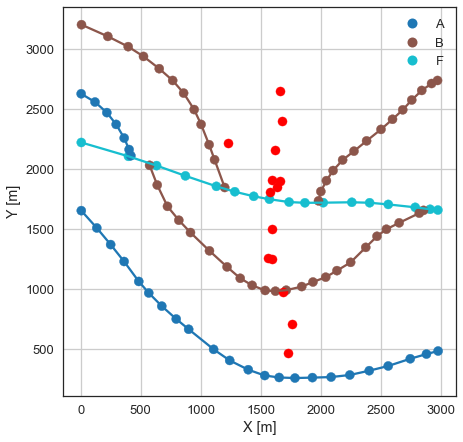

In [18]:
fig, ax = plt.subplots(1)

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## GemPy Model Construction

The structural geological model will be constructed using the `GemPy` package. 

In [19]:
import gempy as gp

### Creating new Model

In [20]:
geo_model = gp.create_model('Model9')
geo_model

Model9  2021-03-29 18:05

### Initiate Data

In [21]:
gp.init_data(geo_model, [0,2977,0,3731,0,1000], [100,100,100],
             surface_points_df = interfaces_coords[interfaces_coords['Z']!=0],
             orientations_df = orientations,
             default_values=True)

Active grids: ['regular']


Model9  2021-03-29 18:05

### Model Surfaces

In [22]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,F,Default series,1,#015482,1
1,B,Default series,2,#9f0052,2
2,A,Default series,3,#ffbe00,3


### Mapping the Stack to Surfaces

In [23]:
gp.map_stack_to_surfaces(geo_model,
                         {
                            
                          'Fault1': ('F'),   
                          'Strata1': ('B', 'A'),
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('C')
geo_model.set_is_fault(['Fault1'])

Fault colors changed. If you do not like this behavior, set change_color to False.


,order_series,BottomRelation,isActive,isFault,isFinite
Fault1,1,Fault,True,True,False
Strata1,2,Erosion,True,False,False


### Showing the Number of Data Points

In [24]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
0,F,Fault1,1,#527682,1,17,3
1,B,Strata1,1,#9f0052,2,49,6
2,A,Strata1,2,#ffbe00,3,30,5
3,C,Strata1,3,#728f02,4,0,0


### Loading Digital Elevation Model

In [25]:
geo_model.set_topography(
    source='gdal', filepath=file_path + 'raster9.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[  14.885     ,   18.655     ,    5.        ],
       [  14.885     ,   18.655     ,   15.        ],
       [  14.885     ,   18.655     ,   25.        ],
       ...,
       [2972.00503356, 3705.99329759,  772.98675537],
       [2972.00503356, 3715.99597855,  772.22625732],
       [2972.00503356, 3725.99865952,  771.48016357]])

### Plotting Input Data

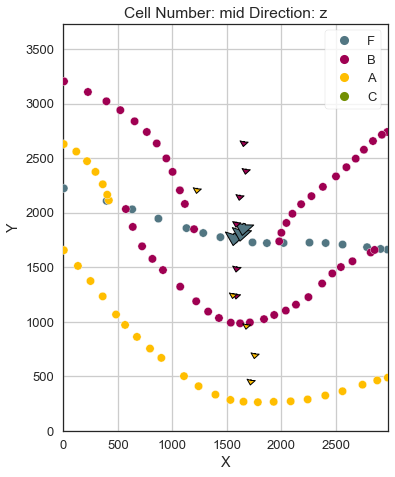

In [26]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

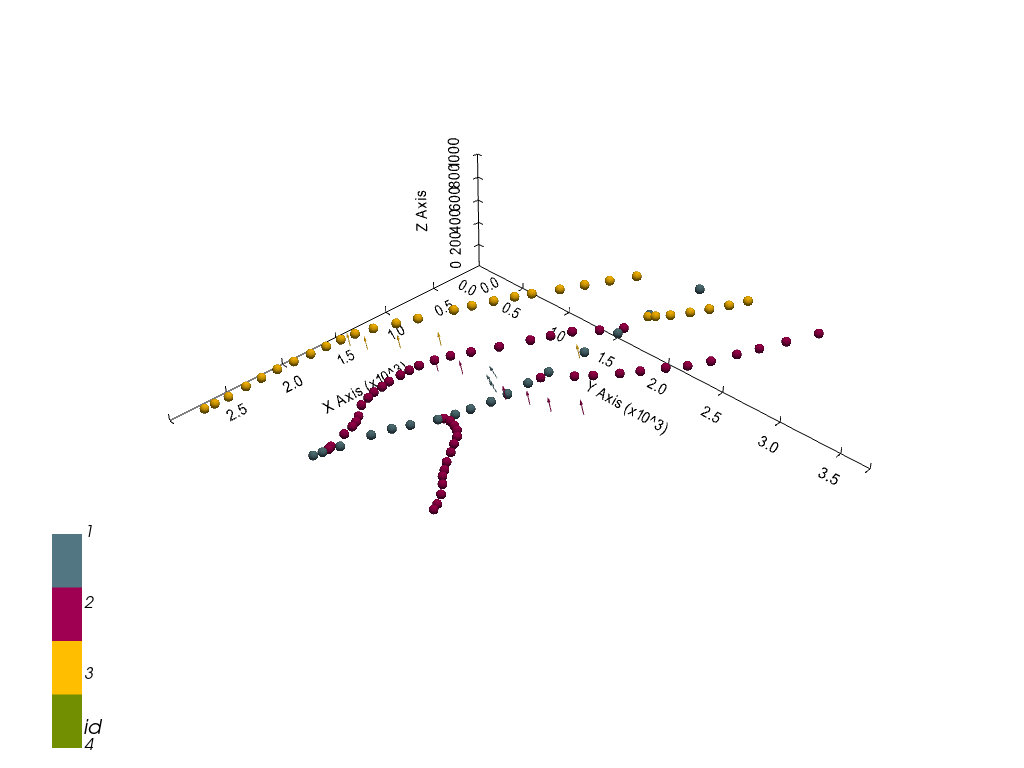

In [27]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

### Setting the Interpolator

In [28]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                    values
range             4876.77
$C_o$           566259.29
drift equations    [3, 3]


### Computing Model

In [29]:
sol = gp.compute_model(geo_model, compute_mesh=True)

MemoryError: Unable to allocate 25.8 MiB for an array with shape (77, 43859) and data type float64

### Plotting Cross Sections

In [ ]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25,75,25,75], show_topography=True, show_data=False)

### Plotting 3D Model

In [ ]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)